In [1]:
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,  roc_curve, precision_recall_curve

In [2]:
df = pd.read_csv('fraud_payments.csv')
df.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,paypal,28.204861,0
1,725,1,4.742303,storecredit,0.000000,0
2,845,1,4.921318,creditcard,0.000000,0
3,503,1,4.886641,creditcard,0.000000,0
4,2000,1,5.040929,creditcard,0.000000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64
 5   label                 39221 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 1.8+ MB


In [4]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,label
count,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000
mean,857.563984,1.084751,4.748232,122.641326,0.014278
std,804.788212,0.566899,0.389360,283.569177,0.118636
min,1.000000,1.000000,0.421214,0.000000,0.000000
25%,72.000000,1.000000,4.742303,0.000000,0.000000
50%,603.000000,1.000000,4.886641,0.012500,0.000000
75%,1804.000000,1.000000,4.962055,87.510417,0.000000
max,2000.000000,29.000000,5.040929,1999.580556,1.000000


In [5]:
df.isnull().sum()

accountAgeDays          0
numItems                0
localTime               0
paymentMethod           0
paymentMethodAgeDays    0
label                   0
dtype: int64

<AxesSubplot:>

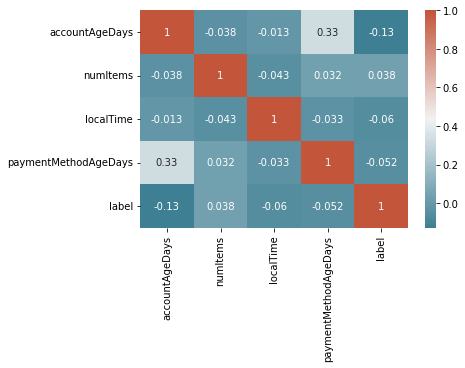

In [6]:
# calculate correlation matrix
corr = df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

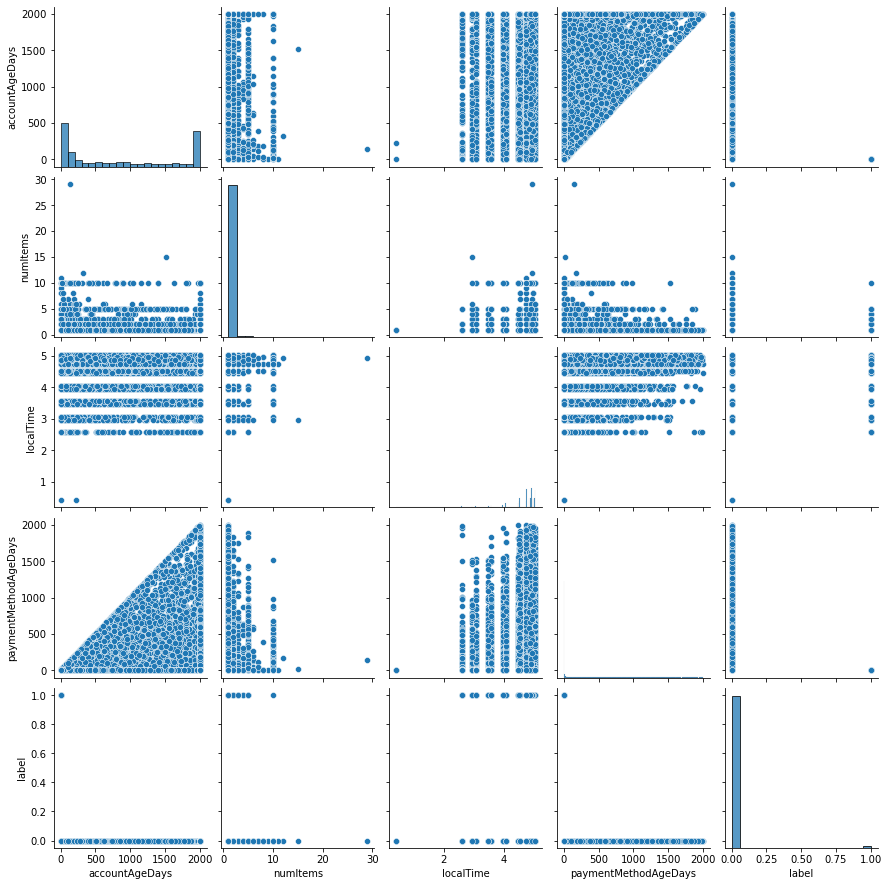

In [7]:
sns.pairplot(df)

<AxesSubplot:ylabel='Frequency'>

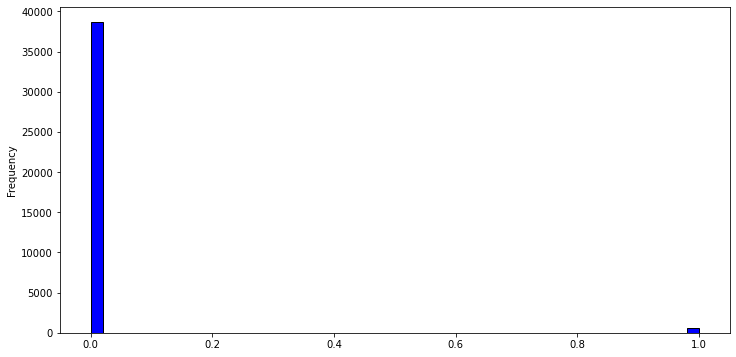

In [8]:
# visualizing the distribution of target variable

df['label'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='blue',edgecolor='black')

In [9]:
# handling categorical variables

encoder = ce.OrdinalEncoder(cols=['paymentMethod'])
df_en= encoder.fit_transform(df)
df_en.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,1,28.204861,0
1,725,1,4.742303,2,0.000000,0
2,845,1,4.921318,3,0.000000,0
3,503,1,4.886641,3,0.000000,0
4,2000,1,5.040929,3,0.000000,0


In [10]:
# Split dataset up into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_en.drop('label', axis=1), df_en['label'],
    test_size=0.33, random_state=17)

In [11]:
class_count_0, class_count_1 = y_train.value_counts()
print('class 0:', class_count_0)
print('class 1:', class_count_1)

class 0: 25908
class 1: 370


# Logistic Regression without Sampling

In [13]:
clf = LogisticRegression().fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_test))

1.0


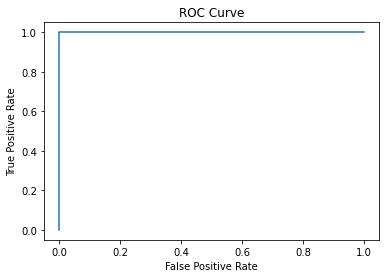

In [14]:
# Plot ROC curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Logistic Regression with ADASYN sampling

Here we can see that we have imbalanced classes and to handel this issue I'm using ADASYN (Adaptive Synthetic Sampling) generates synthetic samples. I'm using this technique because  it focuses on oversampling the hard-to-classify instances which are the most important to the model. 

In [17]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)
print(y_res.value_counts())

1    25910
0    25908
Name: label, dtype: int64


In [18]:
clf = LogisticRegression().fit(X_res, y_res)

# Make predictions on test set
y_pred = clf.predict(X_test)

print(accuracy_score(y_pred, y_test))

1.0


In [19]:
print(confusion_matrix(y_test, y_pred))

[[12753     0]
 [    0   190]]


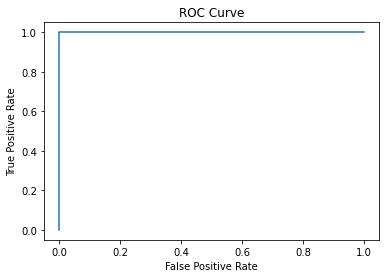

In [20]:
# Plot ROC curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

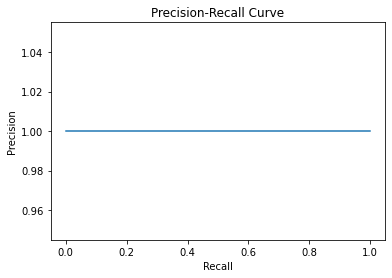

In [21]:
# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Logistic Regression with SMOTE sampling

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X_train, y_train)


In [23]:
clf = LogisticRegression().fit(X_res, y_res)

# Make predictions on test set
y_pred_s = clf.predict(X_test)

print(accuracy_score(y_pred_s, y_test))

1.0


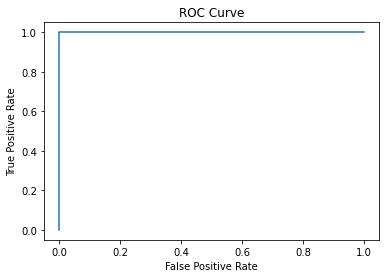

In [24]:
# Plot ROC curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred_s)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

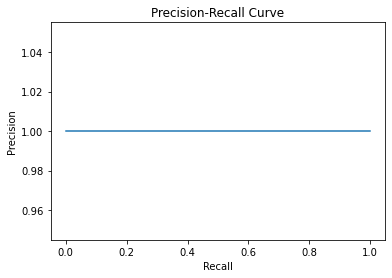

In [25]:
# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_s)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### "Ladies and Gentlemen, buckle up, 'cause we've got a wild ride ahead! Our model is performing like a boss, with an accuracy of 100%, and let's be real, we all know that's about as rare as finding a unicorn in your backyard. But hey, who are we to complain? We're on top of the world!"